# plant.Watering Logistic Regression

## Problem Statement
We should say should the water pump stay off, turn on for medium (480s) or should it turn full (960s)

## Import all libraries

In [1]:
# Show Plot immedeately
%matplotlib inline 

from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
import pymysql.cursors
import pandas as pd
from datetime import datetime


## Import DataSet

In [2]:
r_DataSet = pd.read_csv("plant.Watering.data/DataSet.csv")

## Variables

Variable | Description
------------- |-------------|
Date          |   29 non-null object
Value         |   Pump Duration (predicted variable)29 non-null float64
Time          |   29 non-null object
DateTime_x    |   29 non-null object
DateTime_y    |   29 non-null object
tre200b0      |   Lufttemperatur 2 m über Boden; Stundenmittel 24h ago °C (tre200b0)
ure200b0      |   Relative Luftfeuchtigkeit 2 m über Boden; Stundenmittel 24h ago % (ure200b0)
rre150b0      |   Niederschlag; Stundensumme 24h ago mm (rre150b0)
sre000b0      |   Sonnenscheindauer; Stundensumme 24h ago min (sre000b0)
fu3010b0      |   Windgeschwindigkeit skalar; Stundenmittel 24h ago km/h (fu3010b0)
prestab0      |   24h-Mean Luftdruck auf Stationshöhe (QFE); Stundenmittel (from -48h to -24h) hPa (prestab0)
tre200b0_mean |   24h-Mean Lufttemperatur 2 m über Boden; Stundenmittel (from -48h to -24h) °C (tre200b0)
ure200b0_mean |  24h-Mean Relative Luftfeuchtigkeit 2 m über Boden; Stundenmittel (from -48h to -24h) % (ure200b0)
rre150b0_sum  |   24h-Summe Niederschlag; Stundensumme (from -48h to -24h) mm (rre150b0)
sre000b0_sum  |  24h-Summe Sonnenscheindauer; Stundensumme (from -48h to -24h) min (sre000b0)
fu3010b0_mean |   24h-Mean Windgeschwindigkeit skalar; Stundenmittel (from -48h to -24h) km/h (fu3010b0)
prestab0_mean |   24h-Mean Luftdruck auf Stationshöhe (QFE); Stundenmittel (from -48h to -24h) hPa (prestab0)

In [21]:
# Print more than one variable
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

r_DataSet.describe()
r_DataSet.info()

,Value,tre200b0,ure200b0,rre150b0,sre000b0,fu3010b0,prestab0,tre200b0_mean,ure200b0_mean,rre150b0_sum,sre000b0_sum,fu3010b0_mean,prestab0_mean
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,9.400000e+01,94.000000,94.000000,94.000000
mean,509.800532,17.303191,67.803191,0.135106,9.031915,7.925532,959.015957,15.670789,73.659885,4.319149e+00,437.797872,6.230895,959.794902
std,304.832315,6.672161,15.811412,0.799826,17.558781,5.447164,5.529166,5.976267,10.627121,9.715206e+00,301.206626,2.246432,5.266444
min,1.909000,0.200000,28.400000,0.000000,0.000000,0.000000,938.800000,1.479167,42.308333,2.386980e-15,0.000000,2.625000,944.608333
25%,329.487500,13.800000,56.375000,0.000000,0.000000,4.300000,957.050000,14.409375,66.919792,6.006307e-14,162.500000,4.731250,957.726042
50%,480.000000,18.800000,68.100000,0.000000,0.000000,6.650000,959.450000,17.102083,74.431250,8.797130e-14,426.500000,5.881250,959.893750
75%,674.425250,22.150000,80.500000,0.000000,10.750000,10.325000,961.800000,19.831250,81.696875,3.750000e+00,716.250000,7.269792,963.008333
max,1271.000000,27.200000,95.900000,7.200000,60.000000,31.000000,972.300000,23.945833,94.912500,5.100000e+01,894.000000,15.500000,971.366667


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 15 columns):
Class            94 non-null object
Date             94 non-null object
Value            94 non-null float64
tre200b0         94 non-null float64
ure200b0         94 non-null float64
rre150b0         94 non-null float64
sre000b0         94 non-null float64
fu3010b0         94 non-null float64
prestab0         94 non-null float64
tre200b0_mean    94 non-null float64
ure200b0_mean    94 non-null float64
rre150b0_sum     94 non-null float64
sre000b0_sum     94 non-null float64
fu3010b0_mean    94 non-null float64
prestab0_mean    94 non-null float64
dtypes: float64(13), object(2)
memory usage: 11.1+ KB


## Prepare DataSet
- Pump Log longer than 600s. -> Full Throttle
- Pump Log less than 600s, but more than 100s. -> Turn On
- Pump Log less than 100s -> Do not pump!

In [4]:
r_DataSet.insert(0,"Class","",allow_duplicates=False)
r_DataSet.loc[(r_DataSet.Value < 100), "Class"] = 'Off'

r_DataSet.loc[(r_DataSet.Value > 100) & (r_DataSet.Value < 800), "Class"] = 'Med'
r_DataSet.loc[(r_DataSet.Value > 600), "Class"] = 'High'

r_DataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 15 columns):
Class            94 non-null object
Date             94 non-null object
Value            94 non-null float64
tre200b0         94 non-null float64
ure200b0         94 non-null float64
rre150b0         94 non-null float64
sre000b0         94 non-null float64
fu3010b0         94 non-null float64
prestab0         94 non-null float64
tre200b0_mean    94 non-null float64
ure200b0_mean    94 non-null float64
rre150b0_sum     94 non-null float64
sre000b0_sum     94 non-null float64
fu3010b0_mean    94 non-null float64
prestab0_mean    94 non-null float64
dtypes: float64(13), object(2)
memory usage: 11.1+ KB


## Logistic Regression

### Divide DataSet into TrainingSet (60%) and TestSet (100%) and Define Training Variable (y) and Explanation Variables (X)

In [5]:
p_TrainSet = r_DataSet.sample(frac=0.6, replace=True) #60% of Data
p_TestSet = r_DataSet.sample(frac=1, replace=True) #100% of Data

yTrain = p_TrainSet.Class
yTest = p_TestSet.Class

Xtrain = p_TrainSet.loc[:,"tre200b0":]
# Test Model, get X and y from TestSet
Xtest = p_TestSet.loc[:,"tre200b0":]

### Poly Features

In [6]:
from sklearn.preprocessing import PolynomialFeatures

#polyDegree = 5
#Xtrain = PolynomialFeatures(degree=polyDegree).fit_transform(Xtrain).astype(int)
#Xtest = PolynomialFeatures(degree=polyDegree).fit_transform(Xtest).astype(int)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(yTest)

yTrain = le.transform(yTrain)
yTest = le.transform(yTest)

yTest


/usr/local/lib/python3.4/dist-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


LabelEncoder()

array([1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       2, 1])

### Train Linear Regression and Set Train Variables

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Mean squared error: 0.00
Variance score: 1.00


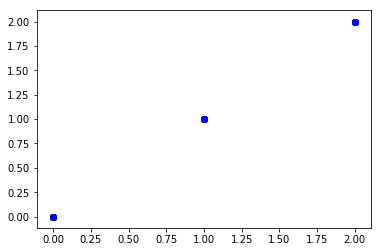

In [7]:
from sklearn import tree
model = tree.DecisionTreeClassifier()

model.fit(X = Xtrain, y = yTrain)

# The coefficients
#print('Coefficients: \n', model.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((model.predict(Xtrain) - yTrain) ** 2) ** 0.5)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model.score(Xtrain, yTrain))

# Plot outputs
plt.scatter(yTrain, model.predict(Xtrain), color='blue')

plt.show()

In [8]:
from sklearn.externals import joblib
#joblib.dump(regr, 'lr_medium_values.pkl', compress=9)

model_clone = model
#model_clone = joblib.load('lr_medium_values.pkl')

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_clone.score(Xtest, yTest))


Variance score: 0.71


In [9]:
pd.DataFrame([le.inverse_transform(yTest), le.inverse_transform(model_clone.predict(Xtest))])

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,Med,High,Med,Med,Med,Off,Med,Med,Med,Med,...,High,Med,Med,High,Med,Med,Med,High,Off,Med
1,Med,High,Med,Med,Off,Off,Med,Med,Med,High,...,High,Off,Med,High,Med,High,Med,High,Off,Off


In [19]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

rowIdx = 85

p_TestSet.iloc[[rowIdx]]
le.inverse_transform(yTest[rowIdx])
le.inverse_transform(model_clone.predict(Xtest)[rowIdx])

le.classes_

,Class,Date,Value,tre200b0,ure200b0,rre150b0,sre000b0,fu3010b0,prestab0,tre200b0_mean,ure200b0_mean,rre150b0_sum,sre000b0_sum,fu3010b0_mean,prestab0_mean
56,Med,2016-08-04,383.0,5.3,89.7,0.1,0.0,7.9,953.1,7.716667,77.2125,0.2,0.0,7.116667,956.191667


'Med'

'Off'

array(['High', 'Med', 'Off'], dtype=object)

## Visualize Decision Tree

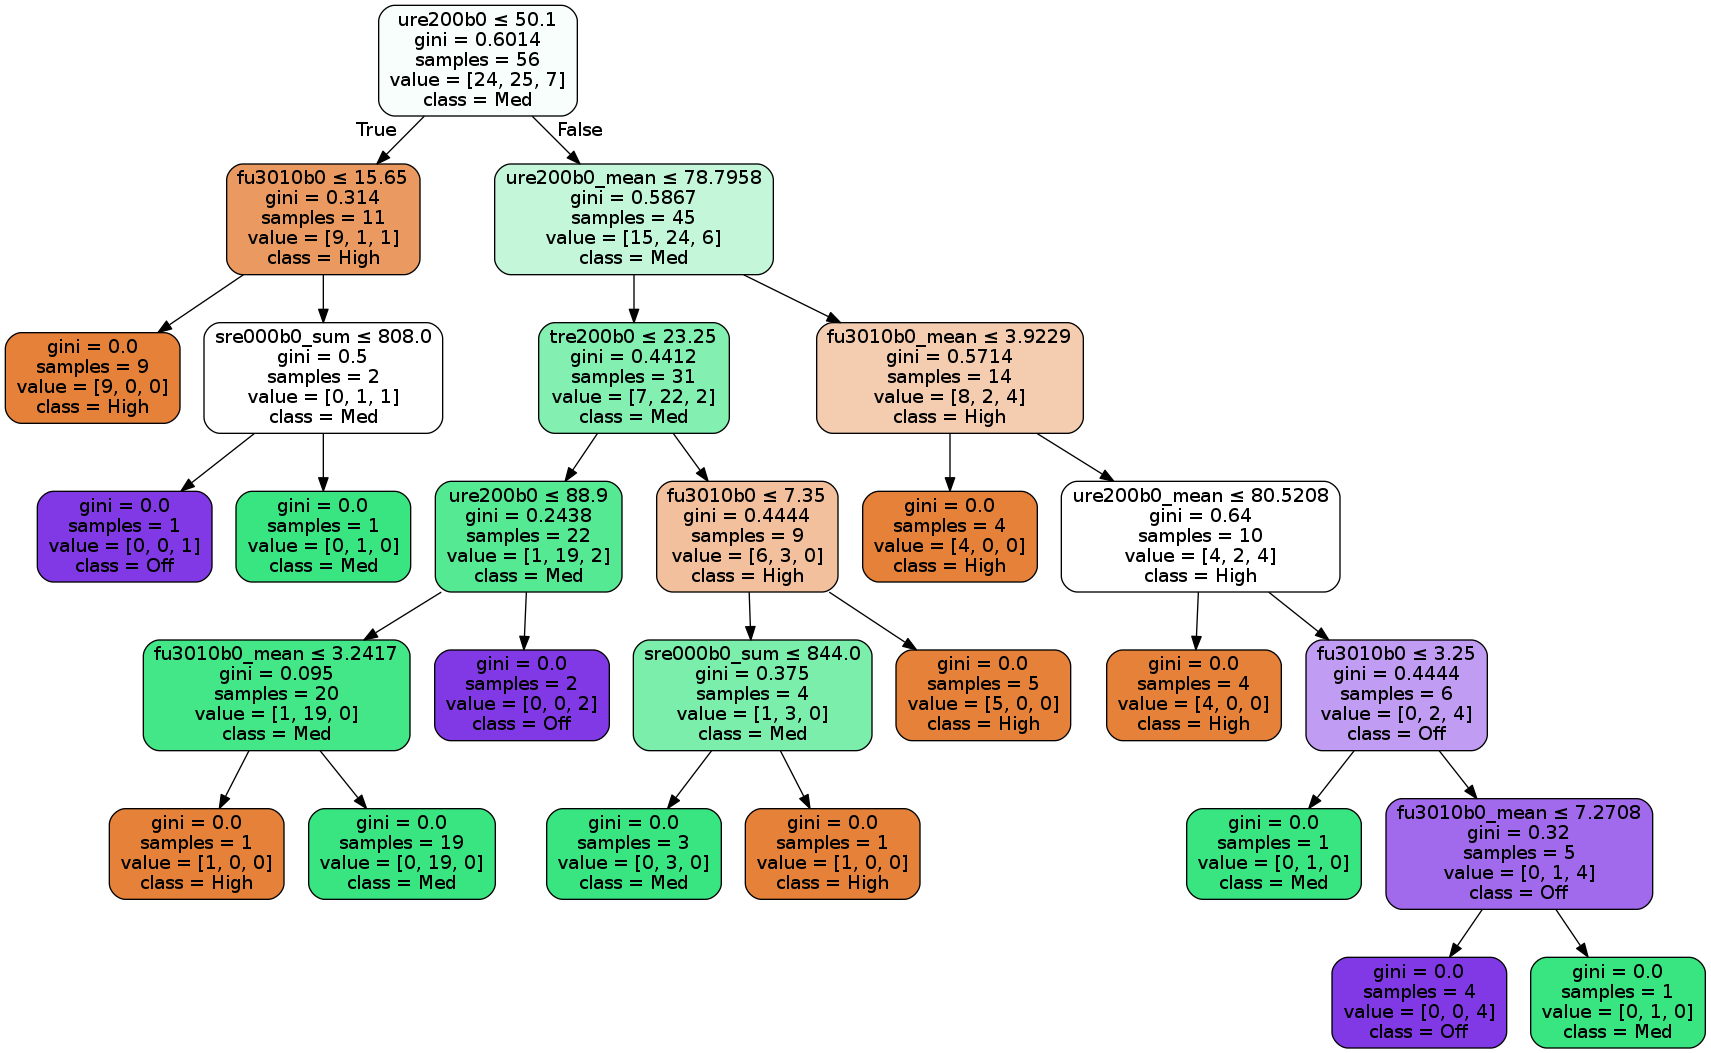

In [20]:
import pydotplus
from IPython.display import Image  

dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=Xtest.columns.values,  
                         class_names=le.classes_,
#                         class_names=["0", "1", "2"],
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)  

#graph.write_pdf("iris.pdf") 
Image(graph.create_png()) 

In [18]:
#Save the model
joblib.dump(model, 'plant.Watering.data/DecTree.pkl', protocol=2)

['plant.Watering.data/DecTree.pkl']

#### Port your model to other languages
Very good source for porting pkl (Pickle) Files to other langauges
https://github.com/nok/sklearn-porter

To export the model into JavaScript, run

```bash
python -m sklearn_porter -i NNClas_5deg.pkl -o NNC -l js 
```